# 4.1 타이타닉 생존자 가려내기

```
pclass : Passenger Class, 승객 등급
survived : 생존 여부
name : 승객 이름
sex : 승객 성별
age : 승객 나이
sibsp : 탑승 한 형제/배우자 수
parch : 탑승 한 부모/자녀 수
ticket : 티켓 번호
fare : 승객 지불 요금
cabin : 선실 이름
embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
body : 사망자 확인 번호
home.dest : 고향/목적지
```

## 1. 탐색 : 타이타닉 데이터 살펴보기

### 기본 정보 확인

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv('data/titanic_train.csv')
df_test = pd.read_csv('data/titanic_test.csv')
print(df_train.shape)
df_train.head()

(916, 13)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-null    int64  
 1   survived   393 non-null    int64  
 2   name       393 non-null    object 
 3   sex        393 non-null    object 
 4   age        305 non-null    float64
 5   sibsp      393 non-null    int64  
 6   parch      393 non-null    int64  
 7   ticket     393 non-null    object 
 8   fare       393 non-null    float64
 9   cabin      81 non-null     object 
 10  embarked   393 non-null    object 
 11  body       36 non-null     float64
 12  home.dest  218 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 40.0+ KB


### 불필요한 feature 제거

```
- 지금 당장 분석에 활용할 수 없는 features : name, cabin
- 큰 의미를 갖고 있지 않은 features : ticket, home.dest, body
```

In [4]:
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

### 탐색적 데이터 분석

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

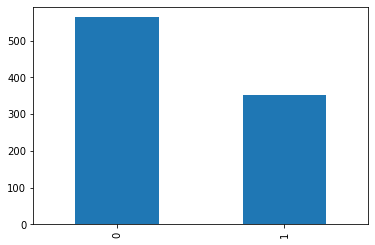

In [5]:
# 생존자 / 비생존자 비교 결과 -> 3:5 정도 비율
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


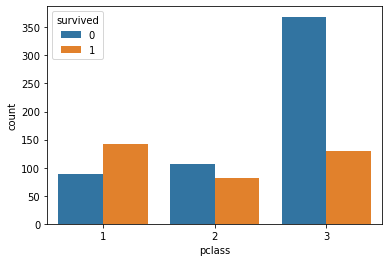

In [6]:
# pclass별 생존/비생존 분포
print(df_train['pclass'].value_counts())
ax = sns.countplot(x='pclass', hue='survived', data=df_train)

- 생존 / 비생존의 pclass 분포 상이하게 나타났다.  
    => __'pclass feature는 생존자 분류에 유의미한 영향을 미친다'__는 가설 세울 수 있음.

#### 수치형 features 중 'age', 'sibsp' 탐색

In [7]:
from scipy import stats

def valid_features(df, col_name, distribution_check=True):
    
    # survived 분포 그래프 출력
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30) # col_name 별 다중 plot 시각화
    
    # survived (0/1) 두 집단의 표준 편차 각각 출력
    titanic_survived = df[df['survived']==1] # 생존자만 뽑기
    titanic_survived_static = np.array(titanic_survived[col_name]) # 생존자의 col_name 값 array에 담기
    print('생존 그룹 std : ', '%.2f' %np.std(titanic_survived_static))
    
    titanic_n_survived = df[df['survived']==0] # 비생존자만 뽑기
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print('비생존 그룹 std : ', '%.2f' %np.std(titanic_n_survived_static))
    
    # t-test로 두 집단의 평균 차이 검정
    # 등분산 가정
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    # 이분산 가정
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print('등분산 가정 t-statistics and p-value : %.3f and %.3f' %tTestResult)
    print('이분산 가정 t-statistics and p-value : %.3f and %.3f' %tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 분포의 정규성 정도를 검증
        print('생존 그룹의 w-statistics and p-value : %.3f and %.3f' %stats.shapiro(titanic_survived[col_name]))
        print('비생존 그룹의 w-statistics and p-value : %.3f and %.3f' %stats.shapiro(titanic_n_survived[col_name]))

__<독립 표본 t-검정>__
- statistics가 양수이면 a의 평균이 더 크다고 판단
- pvalue가 특정 수치 미만이면 a와 b의 평균이 같지 않다고 판단  

__<Shapiro-Wilk 검정>__
- 주어진 데이터가 얼마나 정규성을 따르는지, 즉 얼마나 정규분포에 가까운지 측정하는 검정

생존 그룹 std :  14.22
비생존 그룹 std :  13.71
등분산 가정 t-statistics and p-value : -0.546 and 0.585
이분산 가정 t-statistics and p-value : -0.543 and 0.587
생존 그룹의 w-statistics and p-value : 0.982 and 0.001
비생존 그룹의 w-statistics and p-value : 0.968 and 0.000


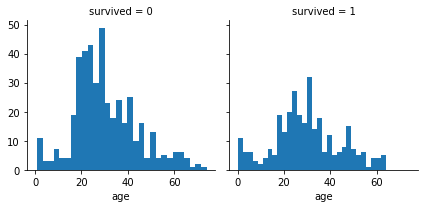

In [8]:
# age 탐색
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)

- age : 두 그룹 간의 평균 차이가 거의 없기 때문에 생존자 분류에 미치는 영향력이 낮을 것이라고 가정해 볼 수 있다.

생존 그룹 std :  0.64
비생존 그룹 std :  1.34
등분산 가정 t-statistics and p-value : -2.118 and 0.034
이분산 가정 t-statistics and p-value : -2.446 and 0.015


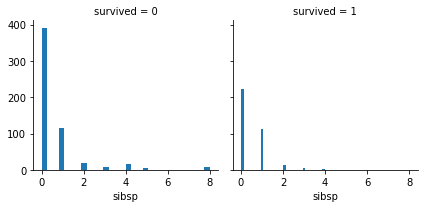

In [9]:
# sibsp 탐색
valid_features(df_train, 'sibsp', distribution_check=False)

- sibsp : 두 그룹 간의 평균 차이가 어느 정도 존재한다는 것을 알 수 있다.

#### 추가적으로 parch, fare, sex, embarked 탐색

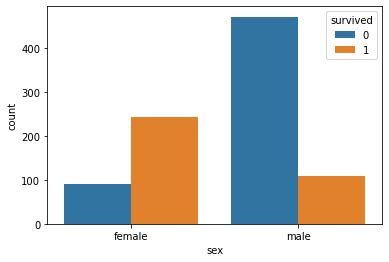

In [10]:
# 성별
ax = sns.countplot(data=df_train, x='sex', hue='survived')

- sex : 남/여에서 생존자와 비생존자 간의 비율이 크게 다른 것을 확인

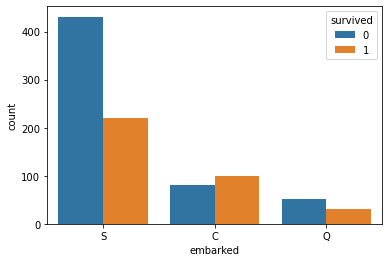

In [11]:
# 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
ax = sns.countplot(data=df_train, x='embarked', hue='survived')

- embarked : 3개의 승선항에 따라 생존자와 비생존자 간의 비율이 부분적으로 다른 것을 확인

생존 그룹 std :  0.74
비생존 그룹 std :  0.89
등분산 가정 t-statistics and p-value : 1.865 and 0.063
이분산 가정 t-statistics and p-value : 1.942 and 0.052


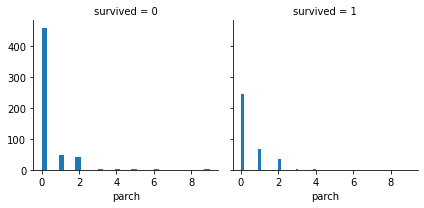

In [12]:
# parch : 탑승 한 부모/자녀 수
valid_features(df_train, 'parch', distribution_check=False)

- parch : 편차에 약간 차이가 있고, t-test 결과 두 집단의 평균에도 약간의 차이가 있는 것을 알 수 있음

생존 그룹 std :  60.68
비생존 그룹 std :  33.65
등분산 가정 t-statistics and p-value : 7.523 and 0.000
이분산 가정 t-statistics and p-value : 6.657 and 0.000


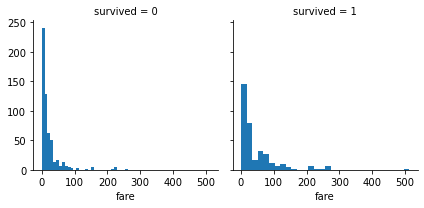

In [13]:
# fare : 승객 지불 요금
valid_features(df_train, 'fare', distribution_check=False)

- fare : 편차에 많은 차이가 있고, t-test 결과 두 집단의 평균은 다르다고 확신할 수 있음

## 2. 분류 : 생존자 분류 모델 만들기

- __로지스틱 회귀 모델__  
: 기존 회귀 분석의 예측값 Y를 0-1 사이의 값으로 제한하여 0.5보다 크면 1, 작으면 0이라고 분류하는 방법  
: 일반적인 회귀 모델과 마찬가지로 계수 분석을 통한 feature의 영향력 해석이 용이하다는 장점이 있다.  


- __결측값이 존재하는 feature를 전처리하는 방법__  
> 1. 결측이 존재하는 데이터들 삭제  
> 2. 평균값, 혹은 중앙값이나 최빈값 등의 임의의 수치로 채워 넣기  
- 1은 처리가 쉽고 분석에서의 주관이 개입될 여지가 적지만 중요한 정보를 삭제할 수 있음.
- 2는 데이터를 모두 분석에 활용할 수 있지만, 수치 왜곡의 가능성이 존재

### 분류 모델 위한 전처리

In [14]:
df_train.isna().sum()

pclass        0
survived      0
sex           0
age         175
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [15]:
df_test.isna().sum()

pclass       0
survived     0
sex          0
age         88
sibsp        0
parch        0
fare         0
embarked     0
dtype: int64

In [16]:
# age의 결측값을 평균값으로 대체
replace_mean = df_train[df_train['age']>0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# 2개의 결측값을 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0] # 최빈값 : S
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩 위한 통합 dataframe 생성
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

# 원-핫 인코딩 수행하고 다시 분리
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


### 로지스틱 회귀 모델링

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [18]:
# 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [19]:
y_pred = lr.predict(x_test)

# predict_proba() : 각 클래스에 대한 예측 확률
y_pred_probability = lr.predict_proba(x_test)[:,1] # 1일때의 예측 확률

### 로지스틱 회귀 모델 평가

- 일반적으로 분류 모델의 평가 기준은 __Confusion Matrix__를 활용한  
    - 정확도(accuracy)  
    - 정밀도(precision)  
    - 재현도(민감도)(recall)  
    - 특이도(specificity)  
- 이 지표들을 응용한 두 가지 평가 지표 : F1-score, ROC curve  
    - F1-score : precision과 recall의 조화 평균값으로, 두 값을 동시에 고려할 때 사용하는 지표  
    - ROC curve : recall과 specificity를 고려하여 종합적인 모델의 성능을 그래프로 나타내는 것. 그래프의 넓이를 계산한 _AUC_ 를 성능의 지표로 사용

In [20]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


In [21]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


#### 로지스틱 회귀 모델 AUC

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

# roc_curve의 y_score: predict_proba()의 반환 값 array에서 positive 칼럼의 예측 확률이 보통 사용
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC : %.3f' %roc_auc)

AUC : 0.838


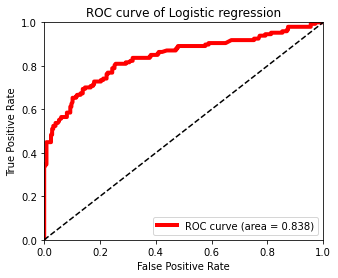

In [23]:
# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5,4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

### Decision Tree 적용

- 로지스틱 회귀 모델과 더불어 분류 분석의 가장 대표적인 방법

In [24]:
from sklearn.tree import DecisionTreeClassifier

# decision tree 학습, 예측
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

# 학습한 모델 성능 계산
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.76
Precision : 0.688
Recall : 0.646
F1 : 0.667


- 로지스틱 회귀 모델에 비해 모든 평가 지표가 낮다.

AUC : 0.750


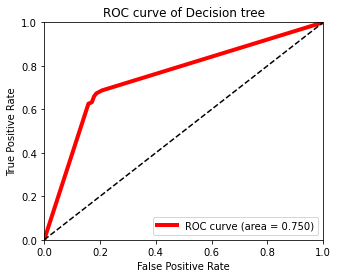

In [25]:
# 학습한 모델의 AUC 계산
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC : %.3f' %roc_auc)

# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5,4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision tree')
plt.legend(loc="lower right")

## 3. 모델 개선 : feature engineering

<분류 모델의 성능을 향상시키기 위한 방법>  
1. 더 좋은 분류 기법 사용 -> 적용 어렵  
2. 더 많은 데이터 사용 -> 적용 어렵  
3. __feature engineering__  

- feature engineering  
: 모델에 사용할 feature를 가공하는 분석 작업

In [26]:
# 데이터 다시 불러오기
df_train = pd.read_csv('data/titanic_train.csv')
df_test = pd.read_csv('data/titanic_test.csv')
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age의 결측값을 평균값으로 대체
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# 2개의 결측값을 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0] # 최빈값 : S
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩 위한 통합 dataframe 생성
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

### cabin(선실 이름) feature 활용

In [27]:
df_train['cabin'].unique()

array([nan, 'E36', 'C68', 'E24', 'C22 C26', 'D38', 'B50', 'A24', 'C111',
       'F', 'C6', 'C87', 'E8', 'B45', 'C93', 'D28', 'D36', 'C125', 'B35',
       'T', 'B73', 'B57 B59 B63 B66', 'A26', 'A18', 'B96 B98', 'G6',
       'C78', 'C101', 'D9', 'D33', 'C128', 'E50', 'B26', 'B69', 'E121',
       'C123', 'B94', 'A34', 'D', 'C39', 'D43', 'E31', 'B5', 'D17', 'F33',
       'E44', 'D7', 'A21', 'D34', 'A29', 'D35', 'A11', 'B51 B53 B55',
       'D46', 'E60', 'C30', 'D26', 'E68', 'A9', 'B71', 'D37', 'F2',
       'C55 C57', 'C89', 'C124', 'C23 C25 C27', 'C126', 'E49', 'F E46',
       'E46', 'D19', 'B58 B60', 'C82', 'B52 B54 B56', 'C92', 'E45',
       'F G73', 'C65', 'E25', 'B3', 'D40', 'C91', 'B102', 'B61', 'F G63',
       'A20', 'B36', 'C7', 'B77', 'D20', 'C148', 'C105', 'E38', 'B86',
       'C132', 'C86', 'A14', 'C54', 'A5', 'B49', 'B28', 'B24', 'C2', 'F4',
       'A6', 'C83', 'B42', 'A36', 'C52', 'D56', 'C116', 'B19', 'E77',
       'F E57', 'E101', 'B18', 'C95', 'D15', 'E33', 'B30', 'D21', 'E1

In [28]:
whole_df['cabin'].value_counts()[:10]

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
C78                4
F4                 4
F33                4
C22 C26            4
D                  4
B96 B98            4
F2                 4
Name: cabin, dtype: int64

In [29]:
# 결측은 'X'로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# 첫 번째 문자 추출
whole_df['cabin'] = whole_df['cabin'].apply(lambda x:x[0])
whole_df['cabin'].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64

- 추출한 결과 G, T는 너무 적기 때문에 X로 대체

In [30]:
whole_df['cabin'] = whole_df['cabin'].replace({'G':'X', 'T':'X'})
whole_df['cabin'].value_counts()

X    1020
C      94
B      65
D      46
E      41
A      22
F      21
Name: cabin, dtype: int64

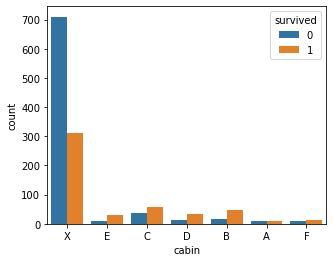

In [31]:
# cabin의 생존자/비생존자 그룹 간 분포
ax = sns.countplot(x='cabin', hue='survived', data=whole_df)
plt.show()

- 생존자/비생존자 그룹 간의 유의미한 차이가 있는 것으로 보인다.  
    => cabin feature를 분류 모델에 사용해 볼 수 있겠다!

### name(승객 이름) feature 활용

In [32]:
whole_df['name'].value_counts()

Connolly, Miss. Kate              2
Kelly, Mr. James                  2
de Pelsmaeker, Mr. Alfons         1
Lester, Mr. James                 1
Aronsson, Mr. Ernst Axel Algot    1
                                 ..
Warren, Mr. Frank Manley          1
Charters, Mr. David               1
Cotterill, Mr. Henry "Harry"      1
Turja, Miss. Anna Sofia           1
Maybery, Mr. Frank Hubert         1
Name: name, Length: 1307, dtype: int64

- 이름의 구성 중간에 있는 __호칭__ 정보를 활용해보자

In [33]:
name_grade = whole_df['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
name_grade

['Miss',
 'Mr',
 'Master',
 'Mrs',
 'Dr',
 'Mlle',
 'Col',
 'Rev',
 'Ms',
 'Mme',
 'Sir',
 'the Countess',
 'Dona',
 'Jonkheer',
 'Lady',
 'Major',
 'Don',
 'Capt']

In [34]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위
              'D': ['Mr', 'Don'], # 남성
              'E': ['Master'], # 젊은남성
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성

In [35]:
# 정의한 호칭의 기준에 따라, A~F의 문자로 name 다시 정의
def give_grade(x):
    grade = x.split(', ',1)[1].split(".")[0]
    for k, v in grade_dict.items():
        for title in v:
            if grade == title:
                return k
    return 'G'

In [36]:
whole_df['name'] = whole_df['name'].apply(lambda x : give_grade(x))
whole_df['name'].value_counts()

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64

### 원-핫 인코딩

In [37]:
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


### 로지스틱 회귀 모델 학습

accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718
AUC : 0.853


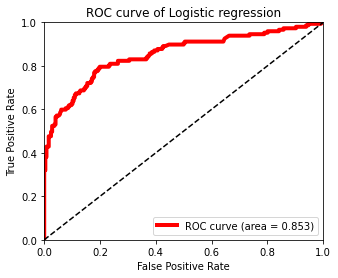

In [38]:
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

# predict_proba() : 각 클래스에 대한 예측 확률
y_pred_probability = lr.predict_proba(x_test)[:,1] # 1일때의 예측 확률

# 평가 지표
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

# AUC 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC : %.3f' %roc_auc)

# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5,4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

### feature 영향력 살펴보기

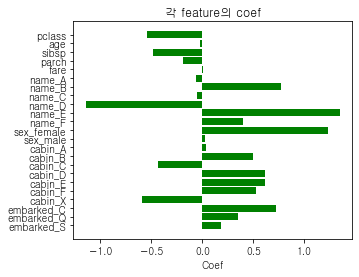

In [39]:
import matplotlib as mpl
# target feature인 survived 제거
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 feature별 회귀 분석 계수를 그래프의 x축으로 하여 feature 영향력 그래프 출력
mpl.rc('font', family='New Gulim')
plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title('각 feature의 coef')
plt.show()

- feature engineering으로 생성된 name, cabin의 영향력이 가장 크다는 것을 알 수 있음.

## 4. 평가 : 모델 검증

### K-fold 교차 검증

- train data와 test data를 나눌 때, 두 data는 불균등하게 나눠졌을 가능성이 있다. 
- K-fold 교차 검증은 이 가능성을 낮춰주는 방법이다.

In [40]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 설정
k=5
cv = KFold(k, shuffle=True, random_state=0)
acc_history = []

# K-fold를 5번의 분할 학습으로 반복
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정
    # 매 반복시마다, 테스트 데이터셋은 변경됨
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values
    
    # 로지스틱 회귀 모델 학습
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    
    # test data의 accuracy를 계산하여 acc_history에 저장
    splited_acc = accuracy_score(splited_y_test, y_pred)
    acc_history.append(splited_acc)

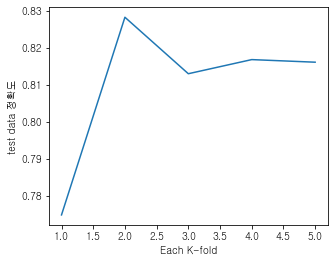

In [41]:
# acc_history에 저장된 5번의 학습 결과(accuracy)를 그래프로 출력
plt.xlabel('Each K-fold')
plt.ylabel('test data 정확도')
plt.plot(range(1, k+1), acc_history)

- 성능이 그렇게 좋지 않음 
- 데이터 수가 적어서...?

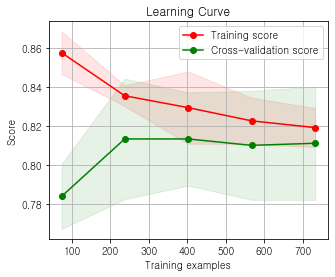

In [42]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()

- train data 수가 증가함에 따라 train / test 두 점수가 어떻게 변화하는지를 관찰한 그래프  
    => 데이터가 300개 이상인 경우에는 overfitting의 위험이 낮아진다는 것을 알 수 있다.